# Figure 3

In [1]:
using DifferentialEquations
using LabelledArrays
using Parameters
using Setfield
using MitochondrialDynamics
import MitochondrialDynamics.Utils: second, μM, mV, mM, Hz

import PyPlot as plt
rcParams = plt.PyDict(plt.matplotlib."rcParams")
rcParams["font.size"] = 14
rcParams["font.sans-serif"] = "Arial"
rcParams["font.family"] = "sans-serif"

"sans-serif"

In [2]:
u0 = LVector(g3p = 2.8μM,
             pyr = 8.5μM,
             nadh_c = 1μM,
             nadh_m = 60μM,
             atp_c = 4000μM,
             adp_c = 500μM,
             ca_m = 0.250μM,
             dpsi = 100mV,
             x2=0.2, x3=0.05)

param0 = MitoDynNode()
ssprob = SteadyStateProblem(model!, u0, param0)

SteadyStateProblem with uType LArray{Float64, 1, Vector{Float64}, (:g3p, :pyr, :nadh_c, :nadh_m, :atp_c, :adp_c, :ca_m, :dpsi, :x2, :x3)}. In-place: true
u0: 10-element LArray{Float64, 1, Vector{Float64}, (:g3p, :pyr, :nadh_c, :nadh_m, :atp_c, :adp_c, :ca_m, :dpsi, :x2, :x3)}:
    :g3p => 0.0028
    :pyr => 0.0085
 :nadh_c => 0.001
 :nadh_m => 0.06
  :atp_c => 4.0
  :adp_c => 0.5
   :ca_m => 0.00025
   :dpsi => 0.1
     :x2 => 0.2
     :x3 => 0.05

In [3]:
function _solve(glc, p::MitoDynNode; tspan=3000.0)
    ssalg= DynamicSS(Rodas5(), tspan=tspan)
    solve(SteadyStateProblem(model!, u0, setglc(p, glc)), ssalg)
end

function solve_f1(glc, r, param0)
    p = @set param0.f1fo.VMAX *= r
    _solve(glc, p)
end

function solve_etc(glc, r, param0)
    p = @set param0.etc.VMAX *= r
    _solve(glc, p)
end

function solve_hl(glc, r, param0)
    p = @set param0.hleak.P_H *= r
    _solve(glc, p)
end

solve_hl (generic function with 1 method)

In [4]:
rGlc1 = LinRange(3.0, 30.0, 50)
rGlc2 = LinRange(4.0, 30.0, 50)
rF1 = LinRange(0.1, 2.0, 50)
rETC = LinRange(0.1, 2.0, 50)
rHL = LinRange(0.1, 5.0, 50)

50-element LinRange{Float64, Int64}:
 0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0,…,4.2,4.3,4.4,4.5,4.6,4.7,4.8,4.9,5.0

In [5]:
uInf_f1 = [solve_f1(glc, r, param0) for r in rF1, glc in rGlc1]
uInf_etc = [solve_etc(glc, r, param0) for r in rETC, glc in rGlc1]
uInf_hl = [solve_hl(glc, r, param0) for r in rHL, glc in rGlc2]

50×50 Matrix{SciMLBase.NonlinearSolution{Float64, 1, LArray{Float64, 1, Vector{Float64}, (:g3p, :pyr, :nadh_c, :nadh_m, :atp_c, :adp_c, :ca_m, :dpsi, :x2, :x3)}, LArray{Float64, 1, Vector{Float64}, (:g3p, :pyr, :nadh_c, :nadh_m, :atp_c, :adp_c, :ca_m, :dpsi, :x2, :x3)}, SteadyStateProblem{LArray{Float64, 1, Vector{Float64}, (:g3p, :pyr, :nadh_c, :nadh_m, :atp_c, :adp_c, :ca_m, :dpsi, :x2, :x3)}, true, MitoDynNode{Float64}, ODEFunction{true, typeof(model!), LinearAlgebra.UniformScaling{Bool}, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, typeof(SciMLBase.DEFAULT_OBSERVED), Nothing}, Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}}, DynamicSS{Rodas5{0, true, Nothing, typeof(OrdinaryDiffEq.DEFAULT_PRECS), Val{:forward}, true, nothing}, Float64, Float64, Float64}, Nothing, Nothing}}:
 [0.00215622, 0.0051562, 0.000640168, 0.0430842, 2.9879, 1.12073, 0.000194725, 0.0890084, 0.219544, 0.151672]      …  [0.00931746, 0.

In [6]:
function plot_fig3(; figsize=(13,10),
                     levels = 40,
                     cmaps = ["bwr", "magma", "viridis"],
                     ylabels = ["ATP synthase capacity (X)",
                                "ETC capacity (X)",
                                "Proton leak rate (X)"],
                     cbarlabels = ["<k>",
			                       "ΔΨ",
		                           "ATP/ADP"],
                     xxs = (rGlc1, rGlc1, rGlc2),
                     xscale = 5.0,
                     yys = (rF1, rETC, rHL),
                     zs  = (uInf_f1, uInf_etc, uInf_hl),
                     extremes=((1.0, 2.0),(80.0, 180.0),(0.0, 60.0)))


    # mapping functions
    fs = (s->avgdeg(s.u), s->s.u.dpsi*1000, s->s.u[:atp_c] / s.u[:adp_c])

    fig, axes = plt.subplots(3, 3, figsize=figsize)

    for col in 1:3
        f = fs[col]
        cm = cmaps[col]
        cbl = cbarlabels[col]
        vmin, vmax = extremes[col]

        # lvls = LinRange(vmin, vmax, levels)
        for row in 1:3
            xx = xxs[row] ./ xscale
            yy = yys[row]
            z  = zs[row]
            ax = axes[row, col]

            ylabel = ylabels[row]

            mesh = ax.pcolormesh(xx, yy, map(f, z),
                shading="gouraud", rasterized=true,
                # levels=levels,
                cmap=cm, vmin=vmin, vmax=vmax)

            ax.set(ylabel=ylabel, xlabel="Glucose (X)")

            # Arrow annotation
            # https://matplotlib.org/stable/tutorials/text/annotations.html#plotting-guide-annotation
            if row == 1
                ax.text(5.5, 1, "Oligomycin", ha="center", va="center", rotation=-90, size=16, bbox=Dict("boxstyle"=>"rarrow", "fc"=>"w", "ec"=>"k", "lw"=>2, "alpha"=>0.5))
            elseif row == 2
                ax.text(5.5, 1, "Rotenone", ha="center", va="center", rotation=-90, size=16, bbox=Dict("boxstyle"=>"rarrow", "fc"=>"w", "ec"=>"k", "lw"=>2, "alpha"=>0.5))
            elseif row == 3
                ax.text(5.5, 2.5, "FCCP", ha="center", va="center", rotation=90, size=16, bbox=Dict("boxstyle"=>"rarrow", "fc"=>"w", "ec"=>"k", "lw"=>2, "alpha"=>0.5))
            end
            cbar = fig.colorbar(mesh, ax=ax)
            cbar.ax.set_title(cbl)
        end
    end

    plt.tight_layout()

    return fig
end

plot_fig3 (generic function with 1 method)

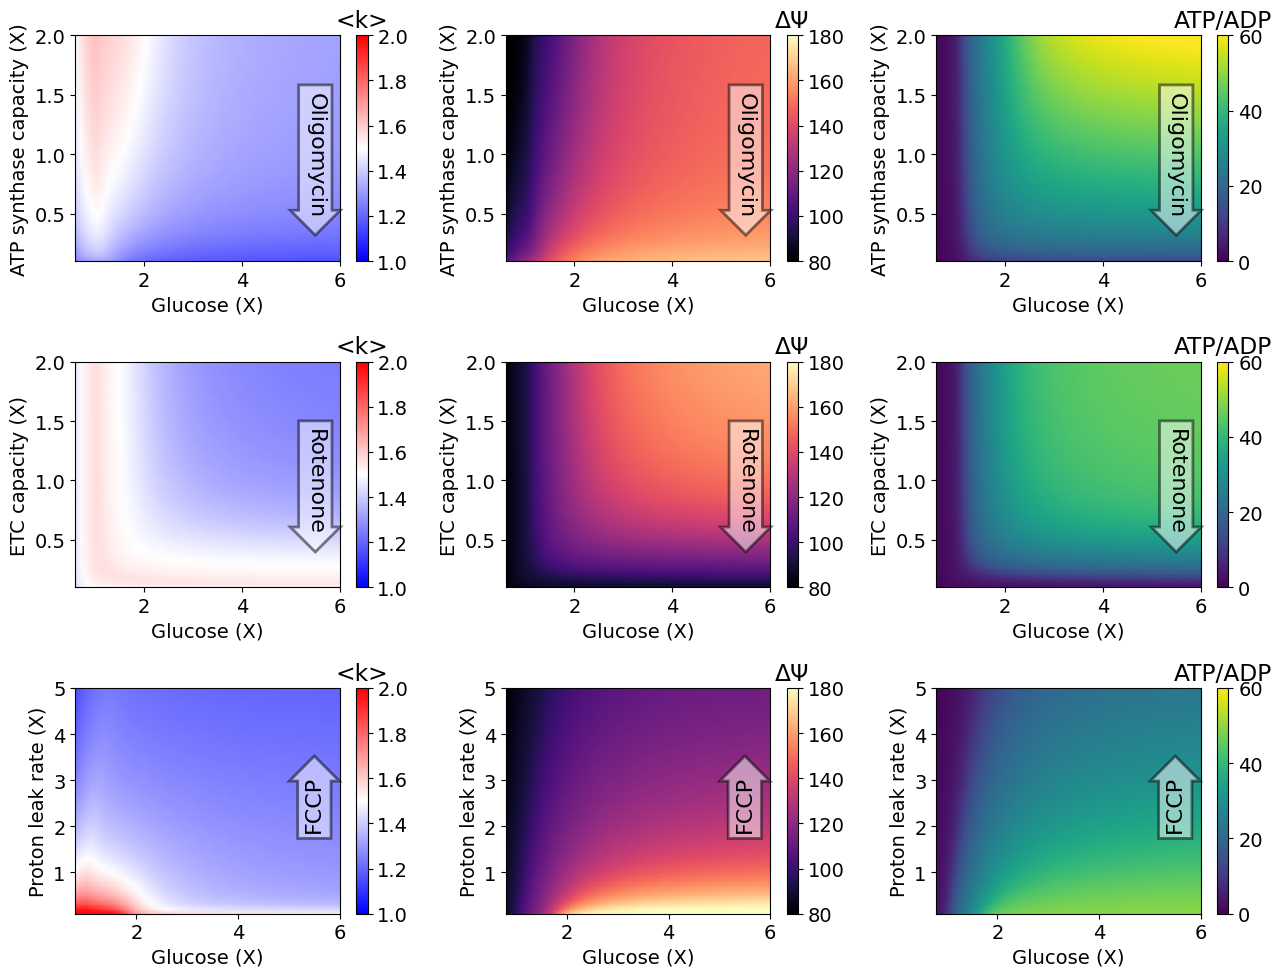

┌ Warning: `vendor()` is deprecated, use `BLAS.get_config()` and inspect the output instead
│   caller = npyinitialize() at numpy.jl:67
└ @ PyCall /builds/NTUMito/MitochondrialDynamics/.julia/packages/PyCall/L0fLP/src/numpy.jl:67
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial


In [7]:
fig3 = plot_fig3();

In [8]:
# Uncomment to generate the pdf file 
# fig3.savefig("Fig3.pdf")